##### Copyright 2021 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
!nvidia-smi

Wed Oct 12 00:35:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     On   | 00000000:3D:00.0 Off |                  Off |
| 33%   28C    P8    14W / 260W |   2520MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 6000     On   | 00000000:3E:00.0 Off |                  Off |
| 33%   

In [4]:
cuda_device_number = 5
!export CUDA_VISIBLE_DEVICES=f"{cuda_device_number}"



<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax_augreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## How to train your ViT? Data, Augmentation, and Regularization in Vision Transformers

Model repository published with the paper

[**How to train your ViT? Data, Augmentation, and Regularization in Vision
Transformers**](https://arxiv.org/abs/2106.10270)

This Colab shows how to
[find checkpoints](#scrollTo=F4SLGDtFxlsC)
in the repository, how to
[select and load a model](#scrollTo=wh_SLkQtQ6K4)
form the repository and use it for inference
([also with PyTorch](#scrollTo=1nMyWmDycpAo)),
and how to
[fine-tune on a dataset](#scrollTo=iAruT3YOxqB6).

For more details, please refer to the repository:

https://github.com/google-research/vision_transformer/

Note that this Colab directly uses the unmodified code from the repository. If
you want to modify the modules and persist your changes, you can do all that
using free GPUs and TPUs without leaving the Colab environment - see

https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax.ipynb

### Imports

In [5]:
# Fetch vision_transformer repository. depth one is just specifying to pull the main branch.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer


In [6]:
import scipy
from scipy.optimize import linear_sum_assignment
import numpy as np
from stratified_sampling import stratify_tfds
import torchvision
from torchvision import transforms

/srv/share/jbjorner3/miniconda3/envs/george-37-v3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-10-04 20:31:20.202022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Install dependencies.
!pip install -qr vision_transformer/vit_jax/requirements.txt

In [8]:
!pip install git+https://github.com/nestordemeure/flaxOptimizers.git

  Cloning https://github.com/nestordemeure/flaxOptimizers.git to /tmp/pip-req-build-j2gfjnnh
  Running command git clone --quiet https://github.com/nestordemeure/flaxOptimizers.git /tmp/pip-req-build-j2gfjnnh
  Resolved https://github.com/nestordemeure/flaxOptimizers.git to commit ae576339948e766449c4019ab5bd83b568b25baa
  Preparing metadata (setup.py) ... done


In [9]:
!pip install flax==0.5.1

In [10]:
import os
print(os.getcwd())
print(os.listdir())

/nethome/jbjorner3/dev/hoffman_group_vision_transformer_soup
['~', 'commands.txt', 'vision_transformer', 'git_rebasin_FIXED.ipynb', 'LICENSE', 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.01-res_224.npz', '.ipynb_checkpoints', '__pycache__', 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.03-res_224.npz', 'permute_to_fit.py', 'README.md', 'stratified_sampling.py', 'environment.yaml', 'Vision_Transformer_AugReg_greedy_soup_v2.ipynb', 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_0k-lr_0.001-res_224.npz', 'Vision_Transformer_AugReg_greedy_soup_v1.ipynb', 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_0k-lr_0.003-res_224.npz', '.gitignore', '.git']


In [11]:
# Import files from repository.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append(os.path.join(os.getcwd(), 'vision_transformer'))

%load_ext autoreload
%autoreload 2

from vision_transformer.vit_jax import checkpoint
from vision_transformer.vit_jax import models
from vision_transformer.vit_jax import train
from vision_transformer.vit_jax.configs import augreg as augreg_config
from vision_transformer.vit_jax.configs import models as models_config

In [12]:
# Connect to TPUs if runtime type is of type TPU.

import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  # Otherwise print information about GPU.
  !nvidia-smi

Tue Oct  4 20:31:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     On   | 00000000:3D:00.0 Off |                  Off |
| 53%   72C    P2   247W / 260W |   9052MiB / 24220MiB |     98%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 6000     Off  | 00000000:3E:00.0 Off |                  Off |
| 33%   

In [13]:
# Some more imports used in this Colab.

import glob
import os
import random
import shutil
import time

from absl import logging
import pandas as pd
import seaborn as sns
import torch
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = None
logging.set_verbosity(logging.INFO)  # Shows logs during training.
device = torch.device(cuda_device_number) if torch.cuda.is_available() else 'cpu'


### Explore checkpoints

This section contains shows how to use the `index.csv` table for model
selection.

See
[`vit_jax.checkpoint.get_augreg_df()`](https://github.com/google-research/vision_transformer/blob/ed1491238f5ff6099cca81087c575a215281ed14/vit_jax/checkpoint.py#L181-L228)
for a detailed description of the individual columns

#### historical exploration


In [14]:
# Load master table from Cloud.
with tf.io.gfile.GFile('gs://vit_models/augreg/index.csv') as f:
  df = pd.read_csv(f)

2022-10-04 20:31:58.889555: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


In [15]:
# This is a pretty large table with lots of columns:
print(f'loaded {len(df):,} rows')
df.columns

loaded 51,509 rows


Index(['name', 'ds', 'epochs', 'lr', 'aug', 'wd', 'do', 'sd', 'best_val',
       'final_val', 'final_test', 'adapt_ds', 'adapt_lr', 'adapt_steps',
       'adapt_resolution', 'adapt_final_val', 'adapt_final_test', 'params',
       'infer_samples_per_sec', 'filename', 'adapt_filename'],
      dtype='object')

In [16]:
# Number of distinct checkpoints
len(tf.io.gfile.glob('gs://vit_models/augreg/*.npz'))

52268

In [17]:
# Any column prefixed with "adapt_" pertains to the fine-tuned checkpoints.
# Any column without that prefix pertains to the pre-trained checkpoints.
len(set(df.filename)), len(set(df.adapt_filename))

(759, 51509)

In [18]:
df.name.unique()

array(['Ti/16', 'S/32', 'B/16', 'L/16', 'R50+L/32', 'R26+S/32', 'S/16',
       'B/32', 'R+Ti/16', 'B/8'], dtype=object)

In [19]:
# Upstream AugReg parameters (section 3.3):
(
df.groupby(['ds', 'name', 'wd', 'do', 'sd', 'aug']).filename
  .count().unstack().unstack().unstack()
  .dropna(1, 'all').fillna(0).astype(int)
  .iloc[:7]  # Just show beginning of a long table.
)

/srv/share/jbjorner3/miniconda3/envs/george-37-v3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  """


aug              light0     light1     medium1     medium2     none      \
sd                  0.0 0.1    0.0 0.1     0.0 0.1     0.0 0.1  0.0 0.1   
do                  0.0 0.1    0.0 0.1     0.0 0.1     0.0 0.1  0.0 0.1   
ds  name    wd                                                            
i1k B/16    0.03     68  68     68  68      68  68      68  68   68  68   
            0.10     68  68     68  68      68  68      68  68   68  68   
    B/32    0.03     68  68     68  68      68  68      68  68   68  68   
            0.10     68  68     68  68      68  68      68  68   68  68   
    L/16    0.03     68  68     68  68      68  68      68  68   68  68   
            0.10     68  68     68  68      68  68      68  68   68  68   
    R+Ti/16 0.03     68  68     68  68      68  68      68  68   68  68   

aug              strong1     strong2      
sd                   0.0 0.1     0.0 0.1  
do                   0.0 0.1     0.0 0.1  
ds  name    wd                            
i1k B/16    0.03      68  68      68  68  
            0.10      68  68      68  68  
    B/32    0.03      68  68      68  68  
            0.10      68  68      68  68  
    L/16    0.03      68  68      68  68  
            0.10      68  68      68  68  
    R+Ti/16 0.03      68  68      68  68

In [20]:
# Downstream parameters (table 4)
# (Imbalance in 224 vs. 384 is due to recently added B/8 checkpoints)
(
df.groupby(['adapt_resolution', 'adapt_ds', 'adapt_lr', 'adapt_steps']).filename
  .count().astype(str).unstack().unstack()
  .dropna(1, 'all').fillna('')
)

/srv/share/jbjorner3/miniconda3/envs/george-37-v3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  


adapt_steps                      500                     2500               \
adapt_lr                         0.001 0.003 0.010 0.030 0.001 0.003 0.010   
adapt_resolution adapt_ds                                                    
224              cifar100                                  759   759   759   
                 imagenet2012                                                
                 kitti             759   759   759   759   759   759   759   
                 oxford_iiit_pet   759   759   759   759   759   759   759   
                 resisc45                                  759   759   759   
384              cifar100                                  756   756   756   
                 imagenet2012                                                
                 kitti             756   756   756   756   756   756   756   
                 oxford_iiit_pet   756   756   756   756   756   756   756   
                 resisc45                                  756   756   756   

adapt_steps                            10000                   20000        
adapt_lr                         0.030 0.001 0.003 0.010 0.030 0.010 0.030  
adapt_resolution adapt_ds                                                   
224              cifar100          759   759   759   759   759              
                 imagenet2012                                    759   759  
                 kitti             759                                      
                 oxford_iiit_pet   759                                      
                 resisc45          759   759   759   759   759              
384              cifar100          756   756   756   756   756              
                 imagenet2012                                    756   755  
                 kitti             756                                      
                 oxford_iiit_pet   756                                      
                 resisc45          756   756   756   756   756

In [21]:
# Let's first select the "best checkpoint" for every model. We show in the
# paper (section 4.5) that one can get a good performance by simply choosing the
# best model by final pre-train validation accuracy ("final-val" column).
# Pre-training with imagenet21k 300 epochs (ds=="i21k") gives the best
# performance in almost all cases (figure 6, table 5).
best_filenames = set(
    df.query('ds=="i1k"')
    .groupby('name')
    .apply(lambda df: df.sort_values('final_val').iloc[-1])
    .filename
)

# Select all finetunes from these models.
best_df = df.loc[df.filename.apply(lambda filename: filename in best_filenames)]

# Note: 9 * 68 == 612
len(best_filenames), len(best_df)

(9, 612)

In [22]:
# df.query(f"adapt_ds=='oxford_iiit_pet' and ds=='i21k' and name=='B/16' and adapt_resolution==224").sort_values(by="adapt_final_test", ascending=False)
df.query(f"adapt_ds=='oxford_iiit_pet' and ds=='i21k_30' and name=='B/16' and adapt_resolution==224").sort_values(by="adapt_final_test", ascending=False)

,name,ds,epochs,lr,aug,wd,do,sd,best_val,final_val,...,adapt_ds,adapt_lr,adapt_steps,adapt_resolution,adapt_final_val,adapt_final_test,params,infer_samples_per_sec,filename,adapt_filename
34497,B/16,i21k_30,30.0,0.001,light1,0.10,0.0,0.0,0.471064,0.470186,...,oxford_iiit_pet,0.001,2500,224,0.926630,0.926410,86570000.0,658.56,B_16-i21k_30-30ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0,B_16-i21k_30-30ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--oxford_iiit_pet-steps_2k-lr_0.001-res_224
34499,B/16,i21k_30,30.0,0.001,light1,0.10,0.0,0.0,0.471064,0.470186,...,oxford_iiit_pet,0.010,500,224,0.932065,0.926138,86570000.0,658.56,B_16-i21k_30-30ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0,B_16-i21k_30-30ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--oxford_iiit_pet-steps_0k-lr_0.01-res_224
34905,B/16,i21k_30,30.0,0.001,none,0.10,0.1,0.1,0.461992,0.461787,...,oxford_iiit_pet,0.001,2500,224,0.956522,0.925320,86570000.0,658.56,B_16-i21k_30-30ep-lr_0.001-aug_none-wd_0.1-do_0.1-sd_0.1,B_16-i21k_30-30ep-lr_0.001-aug_none-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.001-res_224
34500,B/16,i21k_30,30.0,0.001,light1,0.10,0.0,0.0,0.471064,0.470186,...,oxford_iiit_pet,0.003,500,224,0.934783,0.925048,86570000.0,658.56,B_16-i21k_30-30ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0,B_16-i21k_30-30ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--oxford_iiit_pet-steps_0k-lr_0.003-res_224
34907,B/16,i21k_30,30.0,0.001,none,0.10,0.1,0.1,0.461992,0.461787,...,oxford_iiit_pet,0.010,500,224,0.951087,0.923957,86570000.0,658.56,B_16-i21k_30-30ep-lr_0.001-aug_none-wd_0.1-do_0.1-sd_0.1,B_16-i21k_30-30ep-lr_0.001-aug_none-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_0k-lr_0.01-res_224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35657,B/16,i21k_30,30.0,0.001,strong2,0.03,0.0,0.0,0.434443,0.434355,...,oxford_iiit_pet,0.001,500,224,0.891304,0.859907,86570000.0,658.56,B_16-i21k_30-30ep-lr_0.001-aug_strong2-wd_0.03-do_0.0-sd_0.0,B_16-i21k_30-30ep-lr_0.001-aug_strong2-wd_0.03-do_0.0-sd_0.0--oxford_iiit_pet-steps_0k-lr_0.001-res_224
34222,B/16,i21k_30,30.0,0.001,strong1,0.03,0.1,0.1,0.411240,0.411191,...,oxford_iiit_pet,0.030,2500,224,0.902174,0.857454,86570000.0,658.56,B_16-i21k_30-30ep-lr_0.001-aug_strong1-wd_0.03-do_0.1-sd_0.1,B_16-i21k_30-30ep-lr_0.001-aug_strong1-wd_0.03-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.03-res_224
34290,B/16,i21k_30,30.0,0.001,strong2,0.03,0.1,0.1,0.405264,0.405176,...,oxford_iiit_pet,0.030,2500,224,0.880435,0.850641,86570000.0,658.56,B_16-i21k_30-30ep-lr_0.001-aug_strong2-wd_0.03-do_0.1-sd_0.1,B_16-i21k_30-30ep-lr_0.001-aug_strong2-wd_0.03-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.03-res_224
34297,B/16,i21k_30,30.0,0.001,strong2,0.03,0.1,0.1,0.405264,0.405176,...,oxford_iiit_pet,0.001,500,224,0.858696,0.843282,86570000.0,658.56,B_16-i21k_30-30ep-lr_0.001-aug_strong2-wd_0.03-do_0.1-sd_0.1,B_16-i21k_30-30ep-lr_0.001-aug_strong2-wd_0.03-do_0.1-sd_0.1--oxford_iiit_pet-steps_0k-lr_0.001-res_224


In [23]:
for ds in df.query(f"adapt_ds=='oxford_iiit_pet' and name=='B/16' and adapt_resolution==224").ds.unique():
    print(ds)
    print(len(df.query(f"adapt_ds=='oxford_iiit_pet' and name=='B/16' and adapt_resolution==224 and ds=='{ds}'")))

i1k
224
i21k
224
i21k_30
224


In [24]:
for adapt_ds in df.query("ds!=''").adapt_ds.unique():
    for name in df.query(f"adapt_ds=='{adapt_ds}'").name.unique():
        for adapt_resolution in df.query(f"adapt_ds=='{adapt_ds}' and name=='{name}'").adapt_resolution.unique():
            models = df.query(f"adapt_ds=='{adapt_ds}' and name=='{name}' and adapt_resolution=={adapt_resolution}")
            if len(models.ds.unique()) > 1:
                print(adapt_ds, f"{models.ds.unique()}", name, adapt_resolution )
                # print(models)
    #         break
    #     break
    # break

                # if len(models) >= 1:
                #     print(models)
        # and ds=="i1k" name=="B/16" and adapt_resolution==224 and
        # break

imagenet2012 ['i1k' 'i21k' 'i21k_30'] Ti/16 384
imagenet2012 ['i1k' 'i21k' 'i21k_30'] Ti/16 224
imagenet2012 ['i21k' 'i1k' 'i21k_30'] S/32 384
imagenet2012 ['i21k' 'i1k' 'i21k_30'] S/32 224
imagenet2012 ['i1k' 'i21k' 'i21k_30'] B/16 384
imagenet2012 ['i1k' 'i21k' 'i21k_30'] B/16 224
imagenet2012 ['i1k' 'i21k' 'i21k_30'] L/16 384
imagenet2012 ['i1k' 'i21k' 'i21k_30'] L/16 224
imagenet2012 ['i1k' 'i21k' 'i21k_30'] R50+L/32 224
imagenet2012 ['i1k' 'i21k' 'i21k_30'] R50+L/32 384
imagenet2012 ['i1k' 'i21k' 'i21k_30'] R26+S/32 224
imagenet2012 ['i1k' 'i21k' 'i21k_30'] R26+S/32 384
imagenet2012 ['i1k' 'i21k' 'i21k_30'] S/16 384
imagenet2012 ['i1k' 'i21k' 'i21k_30'] S/16 224
imagenet2012 ['i1k' 'i21k' 'i21k_30'] B/32 384
imagenet2012 ['i1k' 'i21k' 'i21k_30'] B/32 224
imagenet2012 ['i1k' 'i21k' 'i21k_30'] R+Ti/16 224
imagenet2012 ['i1k' 'i21k' 'i21k_30'] R+Ti/16 384
cifar100 ['i1k' 'i21k' 'i21k_30'] Ti/16 384
cifar100 ['i1k' 'i21k' 'i21k_30'] Ti/16 224
cifar100 ['i21k' 'i1k' 'i21k_30'] S/32 384

In [25]:
best_df.columns

Index(['name', 'ds', 'epochs', 'lr', 'aug', 'wd', 'do', 'sd', 'best_val',
       'final_val', 'final_test', 'adapt_ds', 'adapt_lr', 'adapt_steps',
       'adapt_resolution', 'adapt_final_val', 'adapt_final_test', 'params',
       'infer_samples_per_sec', 'filename', 'adapt_filename'],
      dtype='object')

In [26]:
# Note that this dataframe contains the models from the "i21k_300" column of
# table 3:
best_df.query('adapt_ds=="imagenet2012"').groupby('name').apply(
    lambda df: df.sort_values('adapt_final_val').iloc[-1]
)[[
   # Columns from upstream
   'name', 'ds', 'filename',
   # Columns from downstream
   'adapt_resolution', 'infer_samples_per_sec','adapt_ds', 'adapt_final_test', 'adapt_filename',
]].sort_values('infer_samples_per_sec')

,name,ds,filename,adapt_resolution,infer_samples_per_sec,adapt_ds,adapt_final_test,adapt_filename
name,,,,,,,,
L/16,L/16,i1k,L_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1,384,49.87,imagenet2012,0.76942,L_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--imagenet2012-steps_20k-lr_0.01-res_384
B/16,B/16,i1k,B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1,384,137.92,imagenet2012,0.80750,B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--imagenet2012-steps_20k-lr_0.01-res_384
S/16,S/16,i1k,S_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.0-sd_0.0,384,300.12,imagenet2012,0.80928,S_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384
R50+L/32,R50+L/32,i1k,R50_L_32-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1,384,326.73,imagenet2012,0.76566,R50_L_32-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--imagenet2012-steps_20k-lr_0.01-res_384
R26+S/32,R26+S/32,i1k,R26_S_32-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1,384,560.40,imagenet2012,0.81178,R26_S_32-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--imagenet2012-steps_20k-lr_0.01-res_384
Ti/16,Ti/16,i1k,Ti_16-i1k-300ep-lr_0.001-aug_light0-wd_0.1-do_0.0-sd_0.0,384,609.58,imagenet2012,0.75022,Ti_16-i1k-300ep-lr_0.001-aug_light0-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384
B/32,B/32,i1k,B_32-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1,384,954.94,imagenet2012,0.78108,B_32-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--imagenet2012-steps_20k-lr_0.01-res_384
S/32,S/32,i1k,S_32-i1k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0,384,2153.94,imagenet2012,0.75648,S_32-i1k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384
R+Ti/16,R+Ti/16,i1k,R_Ti_16-i1k-300ep-lr_0.001-aug_light0-wd_0.1-do_0.0-sd_0.0,384,2425.77,imagenet2012,0.73476,R_Ti_16-i1k-300ep-lr_0.001-aug_light0-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384


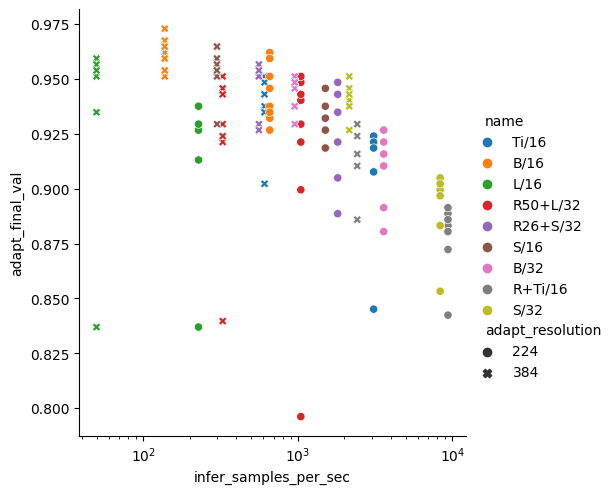

In [27]:
# Visualize the 2 (resolution) * 9 (models) * 8 (lr, steps) finetunings for a
# single dataset (Pets37).
# Note how larger models get better scores up to B/16 @384 even on this tiny
# dataset, if pre-trained sufficiently.
sns.relplot(
    data=best_df.query('adapt_ds=="oxford_iiit_pet"'),
    x='infer_samples_per_sec',
    y='adapt_final_val',
    hue='name',
    style='adapt_resolution'
)
plt.gca().set_xscale('log');

#### Models currently used

In [28]:
best_df.query("ds!='none'").ds.unique() #  and ds=="i1k" name=="B/16" and adapt_resolution==224 and

array(['i1k'], dtype=object)

In [29]:
# More details for a single pre-trained checkpoint.
# another dataset to use is the 
list(best_df.query('name=="B/16" and adapt_resolution==224 and adapt_ds=="oxford_iiit_pet"').adapt_filename) 

['B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.03-res_224',
 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.01-res_224',
 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.003-res_224',
 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.001-res_224',
 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_0k-lr_0.03-res_224',
 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_0k-lr_0.01-res_224',
 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_0k-lr_0.003-res_224',
 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_0k-lr_0.001-res_224']

#### Load a checkpoint

##### loading dataset

In [30]:
# Select a value from "adapt_filename" above that is a fine-tuned checkpoint.
filename = 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.03-res_224'

tfds_name = filename.split('--')[1].split('-')[0]
model_config = models_config.AUGREG_CONFIGS[filename.split('-')[0]]
resolution = int(filename.split('_')[-1])
path = f'gs://vit_models/augreg/{filename}.npz'

print(f'{tf.io.gfile.stat(path).length / 1024 / 1024:.1f} MiB - {path}')

327.5 MiB - gs://vit_models/augreg/B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.03-res_224.npz


In [31]:
# Fetch dataset that the checkpoint was finetuned on.
# (Note that automatic download does not work with imagenet2012)
# gpus = tf.config.list_physical_devices('GPU')
# tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
ds, ds_info = tfds.load(tfds_name, with_info=True)
# preprocess data:
ds_train = ds["train"]
# ds_train = torch.utils.data.DataLoader(ds_train, batch_size=4)
ds_test = ds["test"]

ds_test_split_0, ds_test_split_1 = stratify_tfds(ds_test, .75)
# ds_info

INFO:absl:Load dataset info from ~/tensorflow_datasets/oxford_iiit_pet/3.2.0
INFO:absl:Reusing dataset oxford_iiit_pet (~/tensorflow_datasets/oxford_iiit_pet/3.2.0)
INFO:absl:Constructing tf.data.Dataset oxford_iiit_pet for split None, from ~/tensorflow_datasets/oxford_iiit_pet/3.2.0


In [32]:
# code for ensuring the data distribution is correct.
from stratified_sampling import data_profile
print("total length", len(ds_test_split_0) + len(ds_test_split_1), "from an original ds of size", len(ds_test))
print("prfile of split 0")
print(data_profile(ds_test_split_0))
print("profile of split 1")
print(data_profile(ds_test_split_1))


total length 3669 from an original ds of size 3669
prfile of split 0
Counter({'leonberger': 75, 'Maine_Coon': 75, 'saint_bernard': 75, 'newfoundland': 75, 'basset_hound': 75, 'samoyed': 75, 'great_pyrenees': 75, 'shiba_inu': 75, 'Birman': 75, 'american_pit_bull_terrier': 75, 'american_bulldog': 75, 'havanese': 75, 'Persian': 75, 'pomeranian': 75, 'english_setter': 75, 'pug': 75, 'Siamese': 75, 'Sphynx': 75, 'beagle': 75, 'chihuahua': 75, 'yorkshire_terrier': 75, 'japanese_chin': 75, 'British_Shorthair': 75, 'english_cocker_spaniel': 75, 'german_shorthaired': 75, 'Ragdoll': 75, 'Russian_Blue': 75, 'miniature_pinscher': 75, 'wheaten_terrier': 75, 'Bengal': 75, 'keeshond': 74, 'boxer': 74, 'scottish_terrier': 74, 'Abyssinian': 73, 'Egyptian_Mau': 72, 'Bombay': 66, 'staffordshire_bull_terrier': 66})
profile of split 1
Counter({'beagle': 25, 'yorkshire_terrier': 25, 'havanese': 25, 'keeshond': 25, 'chihuahua': 25, 'american_pit_bull_terrier': 25, 'scottish_terrier': 25, 'Birman': 25, 'great

In [33]:
def pp(img, sz):
    """Simple image preprocessing."""
    img = torch.cast(img, float) / 255.0
    img = torch.image.resize(img, [sz, sz])
    return img
def pp_torch(img, sz):
    """Simple image preprocessing for PyTorch."""
    img = pp(img, sz)
    img = torch.squeeze(img)
    img = torch.transpose(img, [2, 0, 1])  # PyTorch expects NCHW format.
    return img
ds_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.CenterCrop(resolution),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet preprocessing
    ]
)

def data_pp(sample):
    sample["image"] = ds_transforms(sample["image"])
    for key in ["segmentation_mask", "species", "file_name"]: # remove theses
        if key in sample.keys():
            sample.pop(key)
    return sample
# ds_train = ds_train.map(data_pp)

In [34]:
batch_size = 128
ds_train = list(map(data_pp, ds_train.as_numpy_iterator()))
ds_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=False)

ds_test_split_0 = list(map(data_pp, ds_test_split_0))
ds_test_split_1 = list(map(data_pp, ds_test_split_1))
# ds_test_total = torch.utils.data.DataLoader(ds_test_split_0 + ds_test_split_1, batch_size=batch_size, shuffle=False)
ds_test_split_0 = torch.utils.data.DataLoader(ds_test_split_0, batch_size=batch_size, shuffle=False)
ds_test_split_1 = torch.utils.data.DataLoader(ds_test_split_1, batch_size=batch_size, shuffle=False)

/srv/share/jbjorner3/miniconda3/envs/george-37-v3/lib/python3.7/site-packages/torchvision/transforms/functional.py:150: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


## Using `timm`

If you know PyTorch, you're probably already familiar with `timm`.

If not yet - it's your lucky day! Please check out their docs here:

https://rwightman.github.io/pytorch-image-models/

#### model loading

In [35]:
from tqdm import tqdm

In [36]:
# Checkpoints can also be loaded directly into timm...
!pip install timm
import timm
import torch


In [37]:
# For available model names, see here:
# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer_hybrid.py
timm_model = timm.create_model(
    'vit_base_patch16_224', num_classes=ds_info.features['label'].num_classes)

# Non-default checkpoints need to be loaded from local files.
if not tf.io.gfile.exists(f'{filename}.npz'):
  tf.io.gfile.copy(f'gs://vit_models/augreg/{filename}.npz', f'{filename}.npz')
timm.models.load_checkpoint(timm_model, f'{filename}.npz')

In [38]:

def eval_fn(dataset, model):
  acc = 0
  total = 0
  for sample in tqdm(dataset):
    logits = model(torch.Tensor(sample['image']).to(device)).detach().cpu()
    pred = logits.argmax(axis=1)
    if torch.Tensor(pred).shape[0] > 1:
      acc += int(torch.sum(sample["label"] == pred))
    else:
      if sample['label'] == pred:
        acc += 1
    total += int(len(sample["label"]))
  return acc / total

def train_acc(model):
  return eval_fn(ds_train, model)

def validate(model):
  return eval_fn(ds_test_split_0, model)

def test(model):
  return eval_fn(ds_test_split_1, model)

In [39]:
# each model defined by varient, and filename
model_filenames = ['B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.03-res_224',
 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.01-res_224',
#  'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.003-res_224',
#  'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.001-res_224',
#  'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_0k-lr_0.03-res_224',
#  'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_0k-lr_0.01-res_224',
 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_0k-lr_0.003-res_224',
 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_0k-lr_0.001-res_224']
model_types = ['vit_base_patch16_224'] * len(model_filenames)
models = list(zip(model_types, model_filenames))
print(models)

[('vit_base_patch16_224', 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.03-res_224'), ('vit_base_patch16_224', 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.01-res_224'), ('vit_base_patch16_224', 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_0k-lr_0.003-res_224'), ('vit_base_patch16_224', 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_0k-lr_0.001-res_224')]


In [40]:
def generate_complete_model(variant_name, filename):
    timm_model = timm.create_model(
      variant_name, num_classes=ds_info.features['label'].num_classes)
    # Non-default checkpoints need to be loaded from local files.
    if not tf.io.gfile.exists(f'{filename}.npz'):
      tf.io.gfile.copy(f'gs://vit_models/augreg/{filename}.npz', f'{filename}.npz')
    timm.models.load_checkpoint(timm_model, f'{filename}.npz')
    # timm_model = nn.Sequential(*[i for i in timm_model.children()])
    return timm_model

In [41]:
state_dicts = []
for model_type, model_file in tqdm(models):
  state_dicts.append(generate_complete_model(model_type, model_file).state_dict())

100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


In [42]:
def get_model(state_dicts, alphal):
  model = timm.create_model(
      "vit_base_patch16_224", num_classes=ds_info.features['label'].num_classes)
  # feature_dim = state_dicts[0]["head.weight"].shape[1]
  # num_classes = state_dicts[0]["head.weight"].shape[0]
  # normalize = True
  
  sd = {k : state_dicts[0][k].clone() * alphal[0] for k in state_dicts[0].keys()}
  for i in range(1, len(state_dicts)):
      for k in state_dicts[i].keys():
          sd[k] = sd[k] + state_dicts[i][k].clone() * alphal[i]
  model.load_state_dict(sd)
  model = model.to(device)
  return model

#### Baseline 🏁 (model soup)

In [64]:
train_results = []
val_results = []
test_results = []

for i in range(len(state_dicts)):
  model = timm.create_model(
      "vit_base_patch16_224", num_classes=ds_info.features['label'].num_classes)
  # feature_dim = state_dicts[0]["head.weight"].shape[1]
  # num_classes = state_dicts[0]["head.weight"].shape[0]
  # normalize = True
  # model = ModelWrapper(model, feature_dim, num_classes, normalize)
  model.load_state_dict(state_dicts[i])
  model = model.to(device)
  
  train_results.append(train_acc(model))
  val_results.append(validate(model))
  test_results.append(test(model))

100%|██████████| 22/22 [00:10<00:00,  2.11it/s]


In [73]:
names = [f'Model {i+1}' for i in range(len(state_dicts))]

In [109]:
def plot_models(names, results, title, plot=plt):
    plot.bar(names, results)
    ylim = [0.85, 1]
    title = f"{title} Accuracy By Model"
    if plot == plt:
        plot.title(title)
        plot.ylim(ylim)
        plot.xticks(rotation=30, ha='right')
    else:
        plot.set_title(title)
        plot.set_ylim(ylim)
        plot.tick_params(axis="x", labelrotation=30)
def plot_all_models():
    fig, axs = plt.subplots(ncols=3)
    fig.set_size_inches(20, 10)
    plot_models(names, train_results, "Train", axs[0])
    plot_models(names, val_results, "Validation", axs[1])
    plot_models(names, test_results, "Test", axs[2])

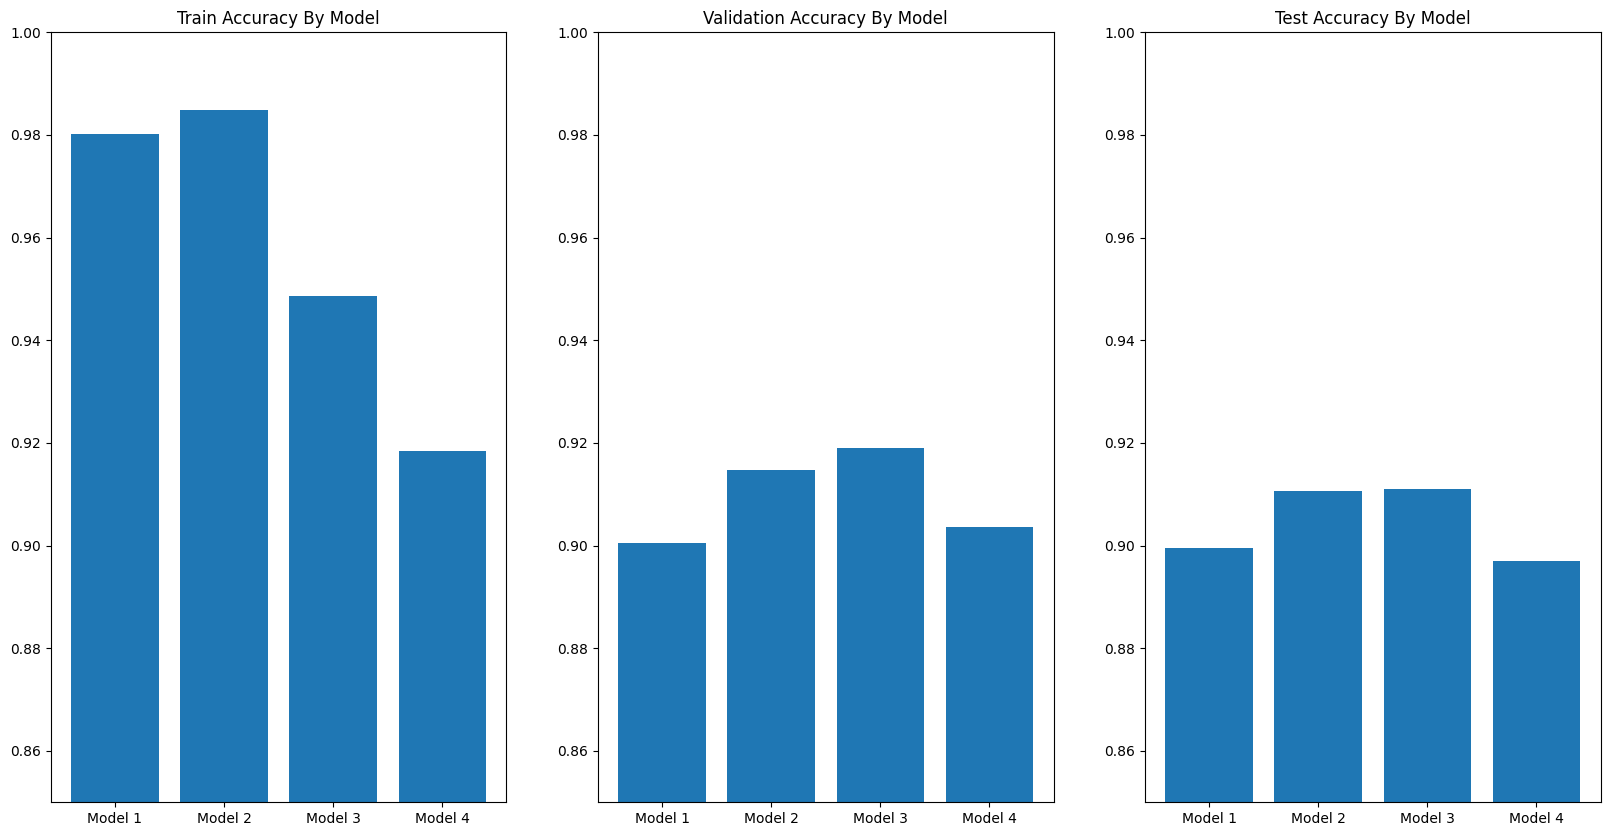

In [93]:
plot_all_models()


#### Uniform Soup

In [94]:
alphal = [1 / len(state_dicts) for i in range(len(state_dicts))]
model = get_model(state_dicts, alphal)
train_results.append(train_acc(model))               
val_results.append(validate(model))
test_results.append(test(model))

100%|██████████| 29/29 [00:13<00:00,  2.12it/s]


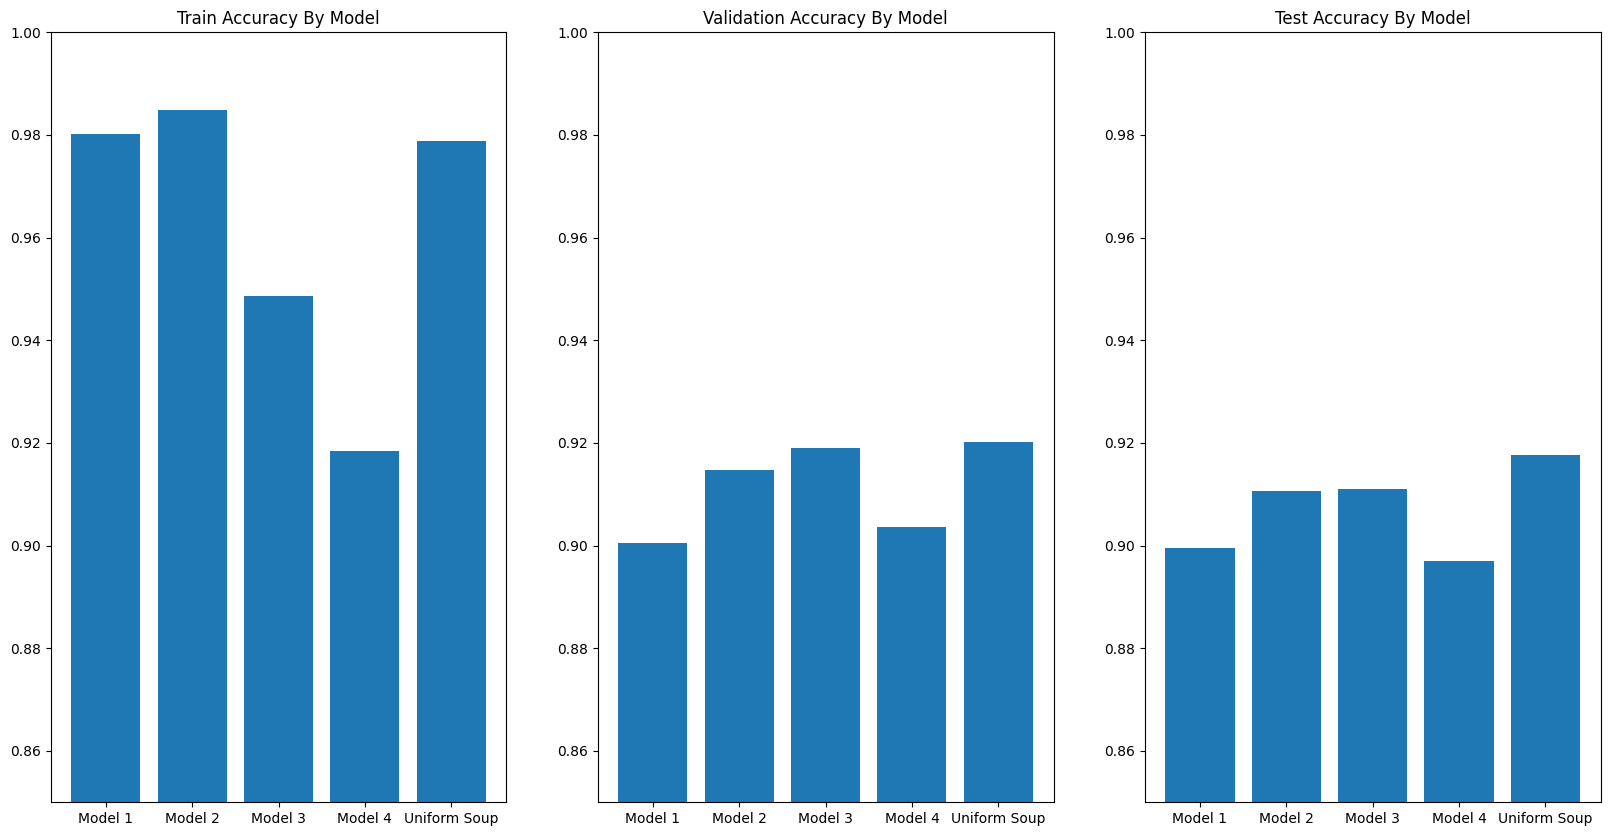

In [97]:
names.append("Uniform Soup") if "Uniform Soup" not in names else None
plot_all_models()

#### Greedy Soup

In [100]:
ranked_candidates = [i for i in range(len(state_dicts))]
ranked_candidates.sort(key=lambda x: -val_results[x])

current_best = val_results[ranked_candidates[0]]
best_ingredients = ranked_candidates[:1]
for i in range(1, len(state_dicts)):
  # add current index to the ingredients
  ingredient_indices = best_ingredients \
    + [ranked_candidates[i]]
  alphal = [0 for i in range(len(state_dicts))]
  for j in ingredient_indices:
    alphal[j] = 1 / len(ingredient_indices)
  
  # benchmark and conditionally append
  model = get_model(state_dicts, alphal)
  current = validate(model)
  print(f'Models {ingredient_indices} got {current*100}% on validation.')
  if current > current_best:
    current_best = current
    best_ingredients = ingredient_indices


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Models [2, 1] got 92.12253829321662% on validation.


100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


Models [2, 1, 3] got 91.46608315098467% on validation.


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]

Models [2, 1, 0] got 92.66958424507659% on validation.


In [101]:
alphal = [0 for i in range(len(state_dicts))]
for j in best_ingredients:
  alphal[j] = 1 / len(best_ingredients)
model = get_model(state_dicts, alphal)
train_results.append(train_acc(model))
val_results.append(validate(model))
test_results.append(test(model))

100%|██████████| 22/22 [00:10<00:00,  2.04it/s]


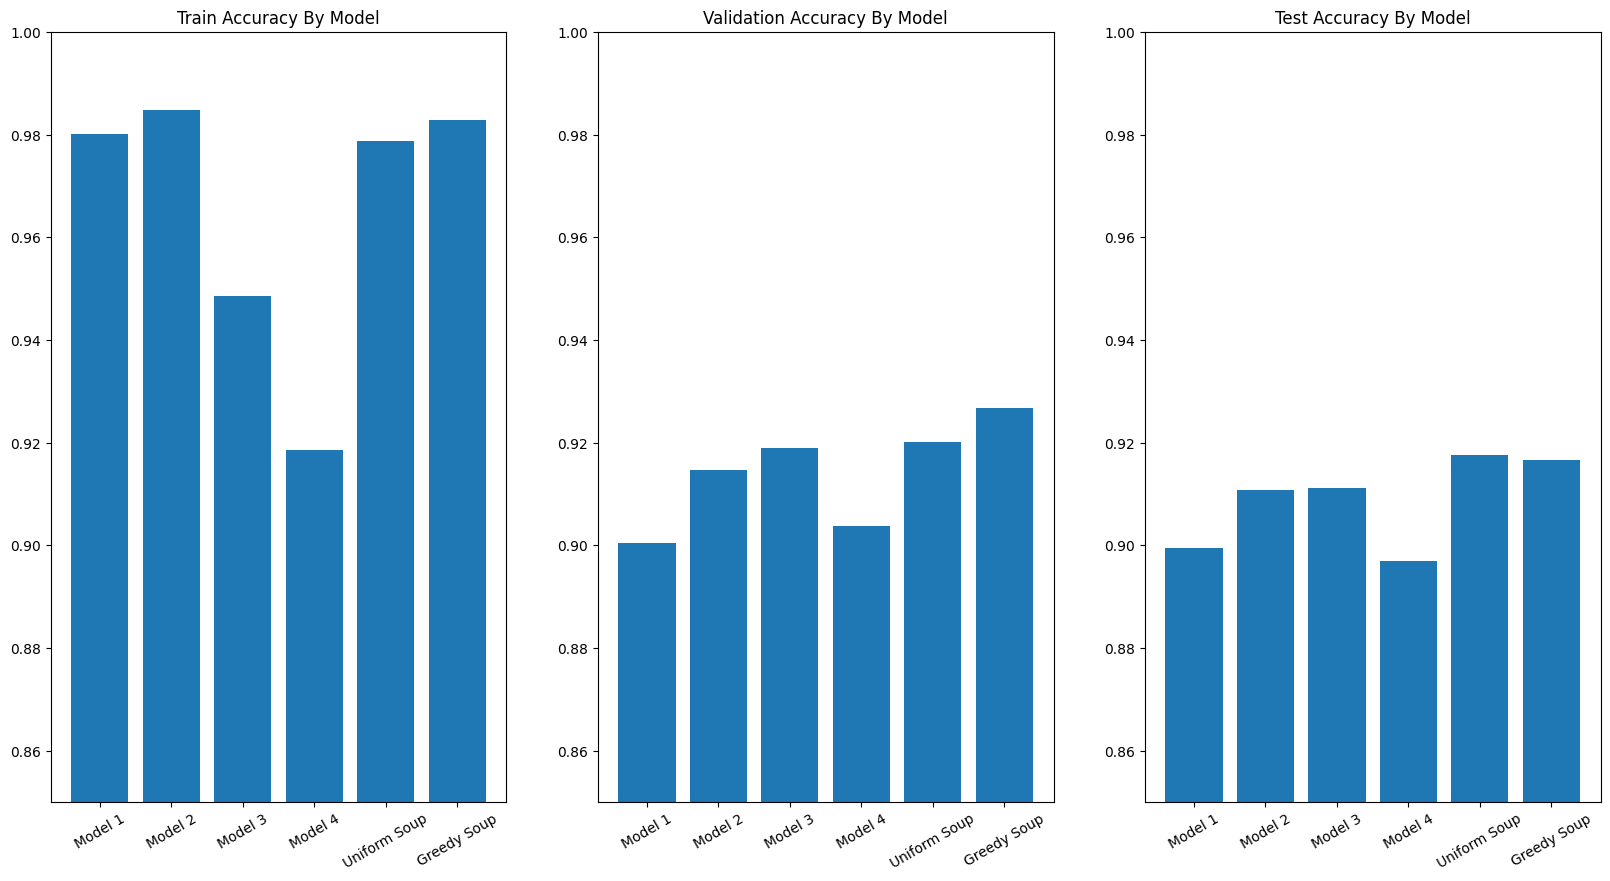

In [110]:
names.append("Greedy Soup") if "Greedy Soup" not in names else None
plot_all_models()

#### permutation matricies across models

In [48]:
#baseline
# Goal to align state dicts and then average them
# taking models who are not already aligned: models 0 and 1
# model 0 and 1 are aligned by they don't improve over model 1

# naive_combo = get_model(state_dicts, [.5,.5, 0, 0])
# print("naive acc:", validate(naive_combo))
# print("model_0 acc:", validate(get_model(state_dicts, [1,0,0,0])))
# print("model_1 acc:", validate(get_model(state_dicts, [0,1,0,0])))
print(
"""
model_0 acc: 0.8988723172062568
model_1 acc: 0.9094216078574027
naive acc: 0.9021462349945435
"""
)
!nvidia-smi



model_0 acc: 0.8988723172062568
model_1 acc: 0.9094216078574027
naive acc: 0.9021462349945435

Tue Oct  4 20:36:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     On   | 00000000:3D:00.0 Off |                  Off |
| 49%   73C    P2   260W / 260W |   9052MiB / 24220MiB |     96%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------

In [52]:
model_target = state_dicts[0]
len(model_target.keys())

152

In [52]:
# sizes of all intermediate inputs and outputs in the model
input_output_dict = {}
def hook(module, x, y):
    if (not hasattr(module, "weight")) or ("norm" in module.__name_):
        return
    input_output_dict[module.__name_] = (x[0].shape, module.weight.shape, y.shape)
model_0 = get_model(state_dicts, [1,0,0,0])
for (name, module) in model_0.named_modules():
    if name == '': continue
    module.__name_ = name
    module.register_forward_hook(hook)
model_0.eval()
validate(model_0)


100%|██████████| 22/22 [00:10<00:00,  2.08it/s]


In [53]:
input_output_dict

{'patch_embed.proj': (torch.Size([61, 3, 224, 224]),
  torch.Size([768, 3, 16, 16]),
  torch.Size([61, 768, 14, 14])),
 'blocks.0.attn.qkv': (torch.Size([61, 197, 768]),
  torch.Size([2304, 768]),
  torch.Size([61, 197, 2304])),
 'blocks.0.attn.proj': (torch.Size([61, 197, 768]),
  torch.Size([768, 768]),
  torch.Size([61, 197, 768])),
 'blocks.0.mlp.fc1': (torch.Size([61, 197, 768]),
  torch.Size([3072, 768]),
  torch.Size([61, 197, 3072])),
 'blocks.0.mlp.fc2': (torch.Size([61, 197, 3072]),
  torch.Size([768, 3072]),
  torch.Size([61, 197, 768])),
 'blocks.1.attn.qkv': (torch.Size([61, 197, 768]),
  torch.Size([2304, 768]),
  torch.Size([61, 197, 2304])),
 'blocks.1.attn.proj': (torch.Size([61, 197, 768]),
  torch.Size([768, 768]),
  torch.Size([61, 197, 768])),
 'blocks.1.mlp.fc1': (torch.Size([61, 197, 768]),
  torch.Size([3072, 768]),
  torch.Size([61, 197, 3072])),
 'blocks.1.mlp.fc2': (torch.Size([61, 197, 3072]),
  torch.Size([768, 3072]),
  torch.Size([61, 197, 768])),
 'block

#### Intermediate feature sizes


In [54]:
info_dict = dict()

model_combo = get_model(state_dicts, [1, -1, 0, 0])
model_combo.train(False)
model_combo_filename = "combo_0-1"
info_dict[model_combo_filename] = {}
def is_useful_module(module, x, y):
  if (not hasattr(module, "weight")) or ("norm" in module.__name_):
    return False
  if 768 not in y.shape:
    return False
  return True
def module_initialize_in_out(module_filename, module_name, input_init, output_init):
  if module_filename not in info_dict:
    info_dict[module_filename] = dict()
  if module_name not in info_dict[module_filename]:
    info_dict[module_filename][module_name] = dict()
  if info_dict[module_filename][module_name] == dict():
    if input_init is not None:
      info_dict[module_filename][module_name]['input'] = input_init
    if output_init is not None:
      info_dict[module_filename][module_name]['output'] = output_init
def create_intermediate_hook(model_combo_filename, model_combo):
  def intermediate_hook(module, x, y):
    if not is_useful_module(module, x, y):
      return
    module_initialize_in_out(module.__filename_, module.__name_, None, list())
    output = y.detach().cpu().numpy()
    info_dict[module.__filename_][module.__name_]['output'].append(np.linalg.norm(output, axis=output.shape.index(768)))
  if model_combo is not None:
    model_combo_modules_dict = dict(model_combo.named_modules())
    def intermediate_hook_add_combo_module_output(module, x, y):
      if not is_useful_module(module, x, y):
        return
      intermediate_hook(module, x, y)
      module_initialize_in_out(model_combo_filename,module.__name_, None, 0)
      mc_output = model_combo_modules_dict[module.__name_].forward(x[0]).detach().cpu().numpy()
      mc_norm = np.linalg.norm(mc_output, axis=mc_output.shape.index(768))
      mc_avged_embed_mag = mc_norm.sum() / (ds_info.splits["test"].num_examples * np.prod(mc_norm.shape[1:]))
      info_dict[model_combo_filename][module.__name_]['output'] += mc_avged_embed_mag
    return intermediate_hook_add_combo_module_output
  return intermediate_hook

model_0 = timm.create_model(
    "vit_base_patch16_224", num_classes=ds_info.features['label'].num_classes)
model_0_filename = model_filenames[0]
model_0.load_state_dict(state_dicts[model_filenames.index(model_0_filename)])
model_0 = model_0.to(device)
info_dict["combo_output_0/1"] = {}
info_dict[model_0_filename] = {}
intermediate_hook_model_0 = create_intermediate_hook(model_combo_filename, model_combo)
for (name, module) in model_0.named_modules():
    if name == '': continue
    module.__name_ = name
    module.__filename_ = model_0_filename
    module.register_forward_hook(intermediate_hook_model_0)

model_1 = timm.create_model(
    "vit_base_patch16_224", num_classes=ds_info.features['label'].num_classes)
model_1_filename = model_filenames[1]
model_1.load_state_dict(state_dicts[model_filenames.index(model_1_filename)])
model_1 = model_1.to(device)
info_dict["combo_output_0/1"] = {}
info_dict[model_1_filename] = {}
intermediate_hook_model_1 = create_intermediate_hook(None, None)
for (name, module) in model_1.named_modules():
    if name == '': continue
    module.__name_ = name
    module.__filename_ = model_1_filename
    module.register_forward_hook(intermediate_hook_model_1)

acc_0 = eval_fn(dataset=ds_test_split_0, model=model_0)
print(acc_0)
acc_1 = eval_fn(dataset=ds_test_split_0, model=model_1)
print(acc_1)


  0%|          | 0/22 [00:13<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 74.00 MiB (GPU 5; 23.65 GiB total capacity; 22.39 GiB already allocated; 71.44 MiB free; 22.60 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [61]:
# find the sum of norms for each layer in model output space between model 0 and model 1

info_dict["combo_output_0/1"] = {}
model_combo_0div1 = info_dict["combo_output_0/1"]
model_0 = info_dict[model_filenames[0]]
model_1 = info_dict[model_filenames[1]]
for module_name in model_0:
    if not module_name: continue 
    # import ipdb; ipdb.set_trace()
    model_combo_0div1[module_name] = np.mean(np.concatenate(model_0[module_name]["output"]) / np.concatenate(model_1[module_name]["output"]))


In [62]:
info_dict["combo_output_0/1"]

{'patch_embed.proj': 1.0936692,
 'blocks.0.attn.proj': 0.9891348,
 'blocks.0.mlp.fc2': 1.0631598,
 'blocks.1.attn.proj': 0.99765795,
 'blocks.1.mlp.fc2': 1.0108193,
 'blocks.2.attn.proj': 0.9931503,
 'blocks.2.mlp.fc2': 1.0034795,
 'blocks.3.attn.proj': 0.9990874,
 'blocks.3.mlp.fc2': 1.0146846,
 'blocks.4.attn.proj': 1.0073664,
 'blocks.4.mlp.fc2': 1.0307245,
 'blocks.5.attn.proj': 1.051597,
 'blocks.5.mlp.fc2': 1.0521607,
 'blocks.6.attn.proj': 1.0493861,
 'blocks.6.mlp.fc2': 1.0481485,
 'blocks.7.attn.proj': 1.0544597,
 'blocks.7.mlp.fc2': 1.0367595,
 'blocks.8.attn.proj': 1.060116,
 'blocks.8.mlp.fc2': 1.0414014,
 'blocks.9.attn.proj': 1.0587739,
 'blocks.9.mlp.fc2': 1.0364692,
 'blocks.10.attn.proj': 1.0469975,
 'blocks.10.mlp.fc2': 1.0095141,
 'blocks.11.attn.proj': 0.9759207,
 'blocks.11.mlp.fc2': 1.020976}

In [69]:
# need to capture outputs on model combination:

# def intermediate_hook(module, x, y):
#   if (not hasattr(module, "weight")) or ("norm" in module.__name_):
#     return
#   output = y.detach().cpu().numpy()
#   if 768 not in output.shape:
#     return
#   if module.__filename_ not in info_dict:
#     info_dict[module.__filename_] = dict()
#   if module.__name_ not in info_dict[module.__filename_]:
#     info_dict[module.__filename_][module.__name_] = dict()
#   if info_dict[module.__filename_][module.__name_] == dict():
#     info_dict[module.__filename_][module.__name_]['output'] = []
#   info_dict[module.__filename_][module.__name_]['output'].append(output)
# model_combo = get_model(state_dicts, [1, -1, 0, 0])
# model_filename = "combo_0-1"
# info_dict[model_filename] = {}
# for (name, module) in model_combo.named_modules():
#     if name == '': continue
#     module.__name_ = name
#     module.__filename_ = model_filename
#     module.register_forward_hook(intermediate_hook)

In [75]:
# how to run a model's layers?
model_0_inputs = info_dict[model_filenames[0]]
for (name, module) in model_combo.named_modules():
    if not name: continue
    module.forward(torch.tensor(model_0_inputs[name]["input"]).to(device))

In [66]:
model_0 = info_dict[model_filenames[0]]
model_0["blocks.7.mlp.fc2"]["output"][0].shape

(128, 197)

In [75]:
# forming df for model combo 0 - 1 norms
df_norms = {"id_name":[], "combo_norm_0-1":[], "shape_after_norm":[],"shape_prod":[], "norm_0/1":[]}
for module_name, module_dict in info_dict["combo_0-1"].items():
    id_name = module_name+"__output"
    shape_after_norm = info_dict[model_filenames[0]][module_name]["output"][0].shape
    norm_0div1 = info_dict["combo_output_0/1"][module_name]

    df_norms["id_name"].append(id_name)
    df_norms["combo_norm_0-1"].append(module_dict["output"])
    df_norms["shape_after_norm"].append(shape_after_norm)
    df_norms["shape_prod"].append(np.prod(shape_after_norm))
    df_norms["norm_0/1"].append(norm_0div1)
df_norms = pd.DataFrame(df_norms)


In [77]:
df_norms.sort_values(by="combo_norm_0-1", ascending=False).iloc[:20]

,id_name,combo_norm_0-1,shape_after_norm,shape_prod,norm_0/1
0,patch_embed.proj__output,6.735024,"(128, 14, 14)",25088,1.093669
24,blocks.11.mlp.fc2__output,1.367581,"(128, 197)",25216,1.020976
20,blocks.9.mlp.fc2__output,1.343390,"(128, 197)",25216,1.036469
2,blocks.0.mlp.fc2__output,1.178854,"(128, 197)",25216,1.063160
22,blocks.10.mlp.fc2__output,1.142544,"(128, 197)",25216,1.009514
3,blocks.1.attn.proj__output,1.067201,"(128, 197)",25216,0.997658
5,blocks.2.attn.proj__output,1.051186,"(128, 197)",25216,0.993150
15,blocks.7.attn.proj__output,0.927767,"(128, 197)",25216,1.054460
13,blocks.6.attn.proj__output,0.915003,"(128, 197)",25216,1.049386
18,blocks.8.mlp.fc2__output,0.904767,"(128, 197)",25216,1.041401


In [129]:
# broken rn. don't think I need to fix... Broke because of batching I believe
info_dict = dict()
def intermediate_hook(module, x, y):
  # print(1)
  if module.__filename_ not in info_dict:
    info_dict[module.__filename_] = dict()
  # print(2, info_dict)
  if module.__name_ not in info_dict[module.__filename_]:
    info_dict[module.__filename_][module.__name_] = dict()
  # print(3)
  if info_dict[module.__filename_][module.__name_] == dict():
    info_dict[module.__filename_][module.__name_]['input'] = []
    info_dict[module.__filename_][module.__name_]['output'] = []
  # print(4)
  info_dict[module.__filename_][module.__name_]['input'].append(x[0].detach().cpu().numpy())
  info_dict[module.__filename_][module.__name_]['output'].append(y.detach().cpu().numpy())

for model_filename in model_filenames + ["uniform", "greedy"]:
  model = timm.create_model(
      "vit_base_patch16_224", num_classes=ds_info.features['label'].num_classes)
  if model_filename in ["uniform", "greedy"]:
    if model_filename == "uniform":
      alphal = [1 / len(state_dicts) for i in range(len(state_dicts))]
      model = get_model(state_dicts, alphal)
    else: # "greedy"
      alphal = [0 for i in range(len(state_dicts))]
      for j in best_ingredients:
        alphal[j] = 1 / len(best_ingredients)
      model = get_model(state_dicts, alphal)
  else: # a base model
    model.load_state_dict(state_dicts[model_filenames.index(model_filename)])
    model = model.to(device)
  for (name, module) in model.named_modules():
      if name == '': continue
      module.__name_ = name
      module.__filename_ = model_filename
      # print("registered")
      module.register_forward_hook(intermediate_hook)
  sample =  iter(ds_test_split_0).next()
  image, label = [x[0] for x in sample.values()]
  acc = eval_fn([{"image":[image], "label": label}], model)
  print(acc)

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: only one element tensors can be converted to Python scalars

In [42]:
print(list(info_dict.keys())[:3])
print(list(info_dict["uniform"].keys())[:3])
print(list(info_dict["uniform"]["patch_embed"].keys()))
print(info_dict["uniform"]["patch_embed.norm"]["output"][0].shape)

['B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.03-res_224', 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.01-res_224', 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_0k-lr_0.003-res_224']
['patch_embed.proj', 'patch_embed.norm', 'patch_embed']
['input', 'output']
(1, 196, 768)


In [43]:
# this is a loop and not done earlier because we may 
# want to take the average of multiple sampels later
flattened_info_dict = dict()
for model_filename in model_filenames + ["uniform", "greedy"]:
  for module_name, item in info_dict[model_filename].items():
    if module_name not in flattened_info_dict:
      flattened_info_dict[module_name] = {"input":[], "output":[]}
    for key_io, io_item in item.items():
      flattened_info_dict[module_name][key_io].append(np.mean(io_item[0])) 

In [90]:
flattened_info_dict

{'patch_embed.proj': {'input': [0.47517386,
   0.47517386,
   0.47517386,
   0.47517386,
   0.47517386,
   0.47517386],
  'output': [0.0023001204,
   0.0023001204,
   0.0023001204,
   0.0023001204,
   0.002389609,
   0.0024179604]},
 'patch_embed.norm': {'input': [0.0023001204,
   0.0023001204,
   0.0023001204,
   0.0023001204,
   0.002389609,
   0.0024179604],
  'output': [0.0023001204,
   0.0023001204,
   0.0023001204,
   0.0023001204,
   0.002389609,
   0.0024179604]},
 'patch_embed': {'input': [0.47517386,
   0.47517386,
   0.47517386,
   0.47517386,
   0.47517386,
   0.47517386],
  'output': [0.0023001204,
   0.0023001204,
   0.0023001204,
   0.0023001204,
   0.002389609,
   0.0024179604]},
 'pos_drop': {'input': [0.0026782914,
   0.0026782914,
   0.0026782914,
   0.0026782914,
   0.002767325,
   0.0027955326],
  'output': [0.0026782914,
   0.0026782914,
   0.0026782914,
   0.0026782914,
   0.002767325,
   0.0027955326]},
 'blocks.0.norm1': {'input': [0.0026782914,
   0.0026782914

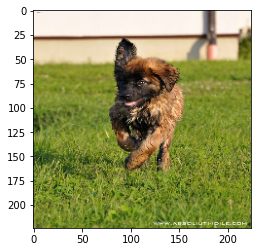

In [55]:
for sample in ds_val_1.take(1):
  image = pp(sample['image'], resolution)
  plt.imshow(image)
plt.show() # 
print("only the greedy model and the uniform model get this one correct!")

In [ ]:
sample_batch = []
for sample in iter(ds['train']):
  if len(sample_batch) >= 1000: break
  sample_batch.append(pp_torch(sample['image'], resolution))


In [ ]:
sample_batch = torch.cat(sample_batch)
sample_batch.shape

torch.Size([1000, 3, 224, 224])

In [ ]:
!nvidia-smi

Thu Sep  8 17:43:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
vit_1 = vit_1.to(device)
vit_2 = vit_2.to(device)

In [ ]:
!nvidia-smi

Thu Sep  8 17:44:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    31W / 250W |   1373MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
(torch.cat([param.reshape(-1) for param in vit_1.parameters()], dim=0) == torch.cat([param.reshape(-1) for param in vit_2.parameters()], dim=0)).sum() / torch.cat([param.reshape(-1) for param in vit_2.parameters()], dim=0).shape[0]

RuntimeError: ignored

In [ ]:
!nvidia-smi

Thu Sep  8 17:44:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    31W / 250W |   1373MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
(vit_2(sample_batch[0].to(device).unsqueeze(0)).squeeze(0).cpu().detach().numpy() == vit_1(sample_batch[0].to(device).unsqueeze(0)).squeeze(0).cpu().detach().numpy()).sum()

In [ ]:
from tqdm import tqdm

In [ ]:
def extract_feature_vectors(samples, models):
  features = [list() for i in models]

  for sample in tqdm(samples):
    outputs = []
    for model in models:
      outputs.append(model(sample.to(device).unsqueeze(0)).squeeze(0).cpu().detach().numpy())
    feature_indices = np.arange(outputs[0].shape[0])
    # sample_features_indices = np.random.choice(feature_indices, 196)

    for feature, output in zip(features, outputs):
      feature.append(output[feature_indices])
  for idx, _ in enumerate(features):
    features[idx] = np.concatenate(features[idx], axis=0)
  return features

In [ ]:
features = extract_feature_vectors(sample_batch, [vit_1, vit_2])

100%|██████████| 1000/1000 [00:20<00:00, 48.69it/s]


In [ ]:
features = np.array(features)
features.shape

(2, 196000, 768)

In [ ]:
bias_offset = np.ones((features.shape[1], 1))
bias_offset.shape, features[0].shape

((196000, 1), (196000, 768))

In [ ]:
biased_features = np.concatenate((features[0], bias_offset), axis=-1)
biased_features.shape

(196000, 769)

In [ ]:
np.sum(features[0] == features[1])

6

In [ ]:
feature_mapper, residues, rank, singular_values = scipy.linalg.lstsq(a=features[0], b=features[1])

In [ ]:
feature_mapper

array([[ 7.7729684e-01,  7.3238201e-03,  2.8361082e-02, ...,
         1.2136647e-02, -1.0738219e-02, -1.9244464e-02],
       [ 1.0063632e-02,  7.6569617e-01, -8.6846799e-03, ...,
        -3.3251218e-02, -9.3407612e-03, -1.1088614e-02],
       [-3.2776233e-02, -1.3500564e-02,  8.2967079e-01, ...,
        -1.9906456e-02,  1.0597018e-02, -5.0191386e-03],
       ...,
       [ 6.0690980e-02,  1.1184085e-02, -5.9742853e-04, ...,
         7.7197772e-01, -1.1093829e-02, -3.8796008e-02],
       [-1.3701764e-03,  2.0219125e-02, -1.0651376e-02, ...,
         2.4699930e-02,  7.9501545e-01,  4.7040456e-03],
       [-4.7748270e-03,  1.4442383e-02,  7.0053921e-03, ...,
        -3.3577345e-04, -3.6453540e-03,  7.9803598e-01]], dtype=float32)

In [ ]:
residues.mean(), rank

(812249.5, 768)

In [ ]:
feature_mapper.shape

(768, 768)

In [ ]:
!nvidia-smi

Thu Sep  8 18:06:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    34W / 250W |   3549MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def generate_complete_model(variant_name, filename):
    timm_model = timm.create_model(
      variant_name, num_classes=ds_info.features['label'].num_classes)
    # Non-default checkpoints need to be loaded from local files.
    if not tf.io.gfile.exists(f'{filename}.npz'):
      tf.io.gfile.copy(f'gs://vit_models/augreg/{filename}.npz', f'{filename}.npz')
    timm.models.load_checkpoint(timm_model, f'{filename}.npz')
    # timm_model = nn.Sequential(*[i for i in timm_model.children()])
    return timm_model

In [ ]:
vit_1_full = generate_complete_model('vit_base_patch16_224', 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_0k-lr_0.001-res_224')
vit_2_full = generate_complete_model('vit_base_patch16_224', 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.001-res_224')

In [ ]:
vit_1_full_sd = vit_1_full.state_dict()
vit_2_full_sd = vit_2_full.state_dict()

In [ ]:
vit_1_full_sd.keys()

odict_keys(['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'blocks.2.attn.proj.bias', 'blocks.2.norm2.weight', 'blocks.2.norm2.bias', 'blocks.2.mlp.fc1.weight', 'blocks.2.mlp.fc1.bias', 'blocks.2.mlp.fc2.weight', 'bloc

In [ ]:
def avg_dicts(dict1, dict2):
  new_dict = {}
  for key in dict1.keys():
    new_dict[key] = (dict1[key] + dict2[key]) / 2.
  return new_dict

In [ ]:
avg_model = avg_dicts(vit_1_full_sd, vit_2_full_sd)

In [ ]:
variant_name = 'vit_base_patch16_224'
vit_avg = timm.create_model(variant_name, num_classes=ds_info.features['label'].num_classes)
vit_avg.load_state_dict(avg_model)

<All keys matched successfully>

In [ ]:
vit_1_full = vit_1_full.cpu()
vit_2_full = vit_2_full.cpu()

In [ ]:
from tqdm import tqdm

In [ ]:
def eval_fn(dataset, model):
  acc = 0
  total = 0
  for sample in tqdm(dataset):
    logits = model(pp_torch(sample['image'], resolution).to(device)).detach().cpu().squeeze(0)
    pred = logits.argmax()
    if sample['label'] == pred: acc+= 1
    total += 1
  return acc / total


In [ ]:
eval_fn(ds['test'], vit_avg.to(device))

100%|██████████| 3669/3669 [01:21<00:00, 44.78it/s]


0.919869174161897

In [ ]:
print(eval_fn(ds['test'], vit_1_full.to(device)))
print(eval_fn(ds['test'], vit_2_full.to(device)))

100%|██████████| 3669/3669 [00:47<00:00, 76.81it/s]


0.8994276369582993


100%|██████████| 3669/3669 [00:46<00:00, 78.08it/s]

0.9296811120196239


In [ ]:
print(feature_mapper.shape)
weight = feature_mapper[:-1]
bias = feature_mapper[-1]
print(weight.shape, bias.shape)

(769, 768)
(768, 768) (768,)


In [ ]:
linear = nn.Linear(768, 768, bias=False, dtype=torch.float32)
linear.weight = torch.nn.Parameter(torch.from_numpy(weight.T).to(torch.float32))
# linear.bias = torch.nn.Parameter(torch.from_numpy(bias).to(torch.float32))

In [ ]:
linear.weight.dtype, linear.bias.dtype

AttributeError: ignored

In [ ]:
vit_2_full_sd = vit_2_full.state_dict()

mapped_state_dict = {}
for key, param_1 in vit_1_full_sd.items():
  param_2 = vit_2_full_sd[key]
  # print(key, param_1.shape, param_2.shape)
  # if 'attn' in key:
  #   if 'qkv' in key:
  #     if 'bias' in key:
  #       param_2 = param_2.reshape(3, 768)
  #       param_2 = linear(param_2)
  #       param_2 = param_2.reshape(-1)
  #     elif 'weight' in key:
  #       param_2 = param_2.reshape(3, 768, 768).permute(0, 2, 1)
  #       param_2 = linear(param_2).permute(0, 2, 1).reshape(2304, 768)
  if 'mlp.fc2' in key:
    if 'weight' in key:
      param_2 = linear(param_2.transpose(1, 0)).transpose(1, 0)
    else:
      param_2 = linear(param_2)
  # if 'patch_embed' in key:
  #   if 'weight' in key:
  #     param_2 = linear(param_2.transpose(0, 3)).transpose(0, 3)
  #   else:
  #     param_2 = linear(param_2)
  # elif 'head' in key:
  #   if 'weight' in key:
  #     param_2 = linear(param_2.transpose(1, 0)).transpose(1, 0)
  #   else:
  #     param_2 = linear(param_2)

  mapped_state_dict[key] = (param_1 + param_2) / 2.
    # param_2 = linear(param_2)
  # except:/
    # mapped_2 = torch.matmul(param_2, torch.from_numpy(feature_mapper))
  

vit_mapped = timm.create_model(variant_name, num_classes=ds_info.features['label'].num_classes)
vit_mapped.load_state_dict(mapped_state_dict)

<All keys matched successfully>

In [ ]:
print(eval_fn(ds['test'], vit_mapped.to(device)))

100%|██████████| 3669/3669 [00:47<00:00, 77.81it/s]

0.9160534205505587


In [ ]:
vit_1_full_sd['blocks.0.attn.qkv.weight'].shape

torch.Size([2304, 768])

In [ ]:
linear(param_2.transpose(3, 0)).shape

torch.Size([16, 3, 16, 768])

# Learn Joint Weight Matrix for Both Models

### Fine-tune

You want to be connected to a TPU or GPU runtime for fine-tuning.

Note that here we're just calling into the code. For more details see the
annotated Colab

https://colab.research.google.com/github/google-research/vision_transformer/blob/linen/vit_jax.ipynb

Also note that Colab GPUs and TPUs are not very powerful. To run this code on
more powerful machines, see:

https://github.com/google-research/vision_transformer/#running-on-cloud

In particular, note that due to the Colab "TPU Node" setup, transfering data to
the TPUs is realtively slow (for example the smallest `R+Ti/16` model trains
faster on a single GPU than on 8 TPUs...)

#### TensorBoard

In [ ]:
# Launch tensorboard before training - maybe click "reload" during training.
%load_ext tensorboard
%tensorboard --logdir=./workdirs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 707), started 0:00:06 ago. (Use '!kill 707' to kill it.)

<IPython.core.display.Javascript object>

#### From tfds

In [ ]:
# Create a new temporary workdir.
workdir = f'./workdirs/{int(time.time())}'
workdir

'./workdirs/1662077282'

In [ ]:
# Get config for specified model.

# Note that we can specify simply the model name (in which case the recommended
# checkpoint for that model is taken), or it can be specified by its full
# name.
config = augreg_config.get_config('R_Ti_16')

# A very small tfds dataset that only has a "train" split. We use this single
# split both for training & evaluation by splitting it further into 90%/10%.
config.dataset = 'tf_flowers'
config.pp.train = 'train[:90%]'
config.pp.test = 'train[90%:]'
# tf_flowers only has 3670 images - so the 10% evaluation split will contain
# 360 images. We specify batch_eval=120 so we evaluate on all but 7 of those
# images (remainder is dropped).
config.batch_eval = 120

# Some more parameters that you will often want to set manually.
# For example for VTAB we used steps={500, 2500} and lr={.001, .003, .01, .03}
config.base_lr = 0.01
config.shuffle_buffer = 1000
config.total_steps = 100
config.warmup_steps = 10
config.accum_steps = 0  # Not needed with R+Ti/16 model.
config.pp['crop'] = 224

In [ ]:
# Call main training loop. See repository and above Colab for details.
state = train.train_and_evaluate(config, workdir)

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: tf_flowers/3.0.1
INFO:absl:Load dataset info from /tmp/tmprx4ogu7ltfds
INFO:absl:Reading dataset from tfds "tf_flowers"
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: tf_flowers/3.0.1
INFO:absl:Load dataset info from /tmp/tmpd_sq954qtfds
INFO:absl:Generating dataset tf_flowers (/root/tensorflow_datasets/tf_flowers/3.0.1)
local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



INFO:absl:Load dataset info from /root/tensorflow_datasets/tf_flowers/3.0.1.incompleteXSDU19
INFO:absl:Constructing tf.data.Dataset for split train[:90%], from /root/tensorflow_datasets/tf_flowers/3.0.1
INFO:absl:Load dataset info from /root/tensorflow_datasets/tf_flowers/3.0.1




Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


INFO:absl:Load dataset info from /root/tensorflow_datasets/tf_flowers/3.0.1
INFO:absl:Reusing dataset tf_flowers (/root/tensorflow_datasets/tf_flowers/3.0.1)
INFO:absl:Constructing tf.data.Dataset for split train[90%:], from /root/tensorflow_datasets/tf_flowers/3.0.1
INFO:absl:Load dataset info from /root/tensorflow_datasets/tf_flowers/3.0.1
INFO:absl:<PrefetchDataset shapes: {image: (1, 512, 224, 224, 3), label: (1, 512, 5)}, types: {image: tf.float32, label: tf.float32}>
INFO:absl:<PrefetchDataset shapes: {image: (1, 120, 224, 224, 3), label: (1, 120, 5)}, types: {image: tf.float32, label: tf.float32}>
INFO:absl:Selected fillename="R_Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0" for "R_Ti_16" with final_val=0.390
INFO:absl:Found no checkpoint file at ./workdirs/1627539136
INFO:absl:Will start/continue training at initial_step=1
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:387: UserWarning: jax.host_count has been renamed to jax.process_count. This alias wi

workdirs/1627539136/checkpoint_100


#### From JPG files

The codebase supports training directly form JPG files on the local filesystem
instead of `tfds` datasets. Note that the throughput is somewhat reduced, but
that only is noticeable for very small models.

The main advantage of `tfds` datasets is that they are versioned and available
globally.

In [ ]:
base = '.'  # Store data on VM (ephemeral).

In [ ]:
# Uncomment below lines if you want to download & persist files in your Google
# Drive instead. Note that Colab VMs are reset (i.e. files are deleted) after
# some time of inactivity. Storing data to Google Drive guarantees that it is
# still available next time you connect from a new VM.

# Note that this is significantly slower than reading from the VMs locally
# attached file system!

# from google.colab import drive
# drive.mount('/gdrive')
# base = '/gdrive/My Drive/vision_transformer_images'

In [ ]:
# Download some dataset & unzip.
! rm -rf '$base/flower_photos'; mkdir -p '$base'
! (cd '$base' && curl https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz | tar xz)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  218M  100  218M    0     0  81.8M      0  0:00:02  0:00:02 --:--:-- 81.8M


In [ ]:
# Since the default file format of above "tf_flowers" dataset is
# flower_photos/{class_name}/{filename}.jpg
# we first need to split it into a "train" (90%) and a "test" (10%) set:
# flower_photos/train/{class_name}/{filename}.jpg
# flower_photos/test/{class_name}/{filename}.jpg

def split(base_dir, test_ratio=0.1):
  paths = glob.glob(f'{base_dir}/*/*.jpg')
  random.shuffle(paths)
  counts = dict(test=0, train=0)
  for i, path in enumerate(paths):
    split = 'test' if i < test_ratio * len(paths) else 'train'
    *_, class_name, basename = path.split('/')
    dst = f'{base_dir}/{split}/{class_name}/{basename}'
    if not os.path.isdir(os.path.dirname(dst)):
      os.makedirs(os.path.dirname(dst))
    shutil.move(path, dst)
    counts[split] += 1
  print(f'Moved {counts["train"]:,} train and {counts["test"]:,} test images.')

split(f'{base}/flower_photos')

Moved 3,303 train and 367 test images.


In [ ]:
# Create a new temporary workdir.
workdir = f'./workdirs/{int(time.time())}'
workdir

'./workdirs/1627539429'

In [ ]:
# Read data from directory containing files.
# (See cell above for more config settings)
config.dataset = f'{base}/flower_photos'

In [ ]:
# And fine-tune on images provided
opt = train.train_and_evaluate(config, workdir)

INFO:absl:Reading dataset from directories "./flower_photos/train" and "./flower_photos/test"
INFO:absl:<PrefetchDataset shapes: {image: (1, 512, 224, 224, 3), label: (1, 512, 5)}, types: {image: tf.float32, label: tf.float32}>
INFO:absl:<PrefetchDataset shapes: {image: (1, 120, 224, 224, 3), label: (1, 120, 5)}, types: {image: tf.float32, label: tf.float32}>
INFO:absl:Selected fillename="R_Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0" for "R_Ti_16" with final_val=0.390
INFO:absl:Found no checkpoint file at ./workdirs/1627539429
INFO:absl:Will start/continue training at initial_step=1
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:387: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:374: UserWarning: jax.host_id has been renamed to jax.process_index.

workdirs/1627539429/checkpoint_100


# New Stuff

In [ ]:
import scipy
from scipy.linalg import lstsq
import numpy as np
import os
import random
# import pandas
import tensorflow as tf
import timm
import torch
from tqdm import tqdm
import tensorflow_datasets as tfds

In [ ]:
def pp(img, sz):
    """Simple image preprocessing."""
    img = tf.cast(img, float) / 255.0
    img = tf.image.resize(img, [sz, sz])
    return img

def pp_torch(img, sz):
    """Simple image preprocessing for PyTorch."""
    img = pp(img, sz)
    img = img.numpy().transpose([2, 0, 1])  # PyTorch expects NCHW format.
    return torch.tensor(img[None])

def generate_complete_model(variant_name, filename):
    timm_model = timm.create_model(
    variant_name, num_classes=ds_info.features['label'].num_classes)
    # Non-default checkpoints need to be loaded from local files.
    if not tf.io.gfile.exists(f'{filename}.npz'):
        tf.io.gfile.copy(f'gs://vit_models/augreg/{filename}.npz', f'{filename}.npz')
    timm.models.load_checkpoint(timm_model, f'{filename}.npz')
    # timm_model = nn.Sequential(*[i for i in timm_model.children()])
    return timm_model

In [ ]:
# Select a value from "adapt_filename" above that is a fine-tuned checkpoint.
filename = 'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.03-res_224'

tfds_name = filename.split('--')[1].split('-')[0]
# model_config = models_config.AUGREG_CONFIGS[filename.split('-')[0]]
resolution = int(filename.split('_')[-1])
path = f'gs://vit_models/augreg/{filename}.npz'

print(f'{tf.io.gfile.stat(path).length / 1024 / 1024:.1f} MiB - {path}')

327.5 MiB - gs://vit_models/augreg/B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_2k-lr_0.03-res_224.npz


In [ ]:
ds, ds_info = tfds.load(tfds_name, with_info=True, download=True, )
ds_info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteFPNE8I/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteFPNE8I/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='~/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=Fa

In [ ]:
vit_base = generate_complete_model(
    'vit_base_patch16_224', 
    'B_16-i1k-300ep-lr_0.001-aug_medium2-wd_0.1-do_0.1-sd_0.1--oxford_iiit_pet-steps_0k-lr_0.001-res_224'
)

In [ ]:
def eval_fn(dataset, model):
    acc = 0
    total = 0
    for sample in tqdm(dataset):
        logits = model(pp_torch(sample['image'], resolution).to(device)).detach().cpu().squeeze(0)
        pred = logits.argmax()
#         import pdb; pdb.set_trace()
    if sample['label'] == pred: acc+= 1
    total += 1
    return acc / total


In [ ]:
eval_fn(ds['test'], vit_base.to(device))

100%|██████████| 3669/3669 [00:49<00:00, 74.47it/s]


0.8994276369582993

In [ ]:
info_dict = {name: {'input': [], 'output': []} for name, _ in vit_1_full.named_modules()}
for ((name, module1), (_, module2)) in zip(vit_1_full.named_modules(), vit_2_full.named_modules()):
    if name == '': continue
    module1.__name_ = name
    module2.__name_ = name
    def intermediate_hook(module, x, y):
        
        info_dict[module.__name_]['input'].append(x[0].detach().cpu().numpy())
        info_dict[module.__name_]['output'].append(y.detach().cpu().numpy())
    module1.register_forward_hook(intermediate_hook)
    module2.register_forward_hook(intermediate_hook)


In [ ]:
def extract_intermediates(data, model):
    for sample in tqdm(data):
        model(sample.to(device).unsqueeze(0)).squeeze(0).cpu().detach().numpy()
    

In [ ]:
sample_batch = []
for sample in iter(ds['train']):
    if len(sample_batch) >= 250: break
    sample_batch.append(pp_torch(sample['image'], resolution))


In [ ]:
sample_batch = torch.cat(sample_batch)
sample_batch.shape

torch.Size([250, 3, 224, 224])

In [ ]:
extract_intermediates(sample_batch, vit_1_full)

  6%|▋         | 16/250 [00:16<04:19,  1.11s/it]

In [ ]:
extract_intermediates(sample_batch, vit_2_full)